## GPFlow Practice Using Dengue Simulation Data

### Resources:
https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.01-Contributed-Example.html

### Setup

In [18]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf


from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [19]:
# specify data file paths

train_path = 'Dengue/Data/Simulation/Duration/DD-AML-train-LHS-5000-condSim-logDuration.txt'
test_path = 'Dengue/Data/Simulation/Duration/DD-AML-test-LHS-10000-condSim-logDuration.txt'

### Load Data

### Train and Test Sets

In [20]:
# load and inspect training set

train_set = pd.read_csv(train_path, sep = "\t")
train_set.head()

simRound   simID  alphaRest  alphaAmp  alphaShift  infTicksCounts  \
0       0.0  2068.0   0.013191    0.5959      0.7999          4.0050   
1       0.0  1595.0   0.026691    0.8901      0.1425          4.7738   
2       0.0  3517.0   0.013959    0.7015      0.5965          5.0506   
3       0.0  1105.0   0.012351    0.5541      0.0989          5.6122   
4       0.0  2918.0   0.014151    0.7141      0.6015          4.2950   

   avgVisitsCounts  pVisits  propSocialVisits  locPerSGCount  maxIncidence  \
0           1.6668  0.61493            0.9667         2.8297      0.000528   
1           4.4996  0.29885            0.3457         2.9893      0.976824   
2           2.1236  0.52673            0.1029        19.0329      0.309819   
3           1.2948  0.08969            0.7879        11.8813      0.399494   
4           2.5860  0.68045            0.4663        16.2437      0.229501   

   epidemicSize  duration  sd_maxIncidence  sd_epidemicSize  sd_duration  
0      0.003083  1.844508         0.000266         0.002098     0.118824  
1      1.000000  1.328368         0.002816         0.000000     0.013705  
2      0.907965  2.165168         0.052430         0.021189     0.031410  
3      0.934596  1.940874         0.004233         0.002088     0.029945  
4      0.879443  2.202382         0.047883         0.023500     0.127659

In [21]:
# load and inspect testing set

test_set = pd.read_csv(test_path, sep = "\t")
test_set.head()

simRound   simID  alphaRest  alphaAmp  alphaShift  infTicksCounts  \
0       0.0  6612.0   0.014174   0.79105     0.49695          4.5621   
1       0.0  5326.0   0.008926   0.05895     0.64495          4.9237   
2       0.0  5607.0   0.012485   0.10485     0.69235          4.8789   
3       0.0  9679.0   0.027352   0.38855     0.75705          4.3033   
4       0.0  3850.0   0.020896   0.56585     0.00695          5.5575   

   avgVisitsCounts   pVisits  propSocialVisits  locPerSGCount  maxIncidence  \
0           4.6622  0.157685           0.00335       12.29455      0.560750   
1           1.7194  0.729995           0.37015       13.12295      0.204179   
2           4.2866  0.153095           0.59785        1.85025      0.788018   
3           2.4138  0.682655           0.32895       19.44805      0.773855   
4           2.5822  0.864005           0.17695       12.17675      0.929093   

   epidemicSize  duration  sd_maxIncidence  sd_epidemicSize  sd_duration  
0      0.983757  1.788234         0.021422         0.002740     0.020726  
1      0.770511  2.079698         0.003692         0.004287     0.028981  
2      0.998619  1.582717         0.003759         0.000146     0.024717  
3      0.998757  1.549363         0.004998         0.000163     0.023228  
4      0.999994  1.480790         0.003044         0.000010     0.013965

In [22]:
# drop non-standardized columns
dcols = ['duration', 'epidemicSize', 'maxIncidence', 'simRound', 'simID']

train_set = train_set.drop(dcols, axis=1)
test_set = test_set.drop(dcols, axis=1)

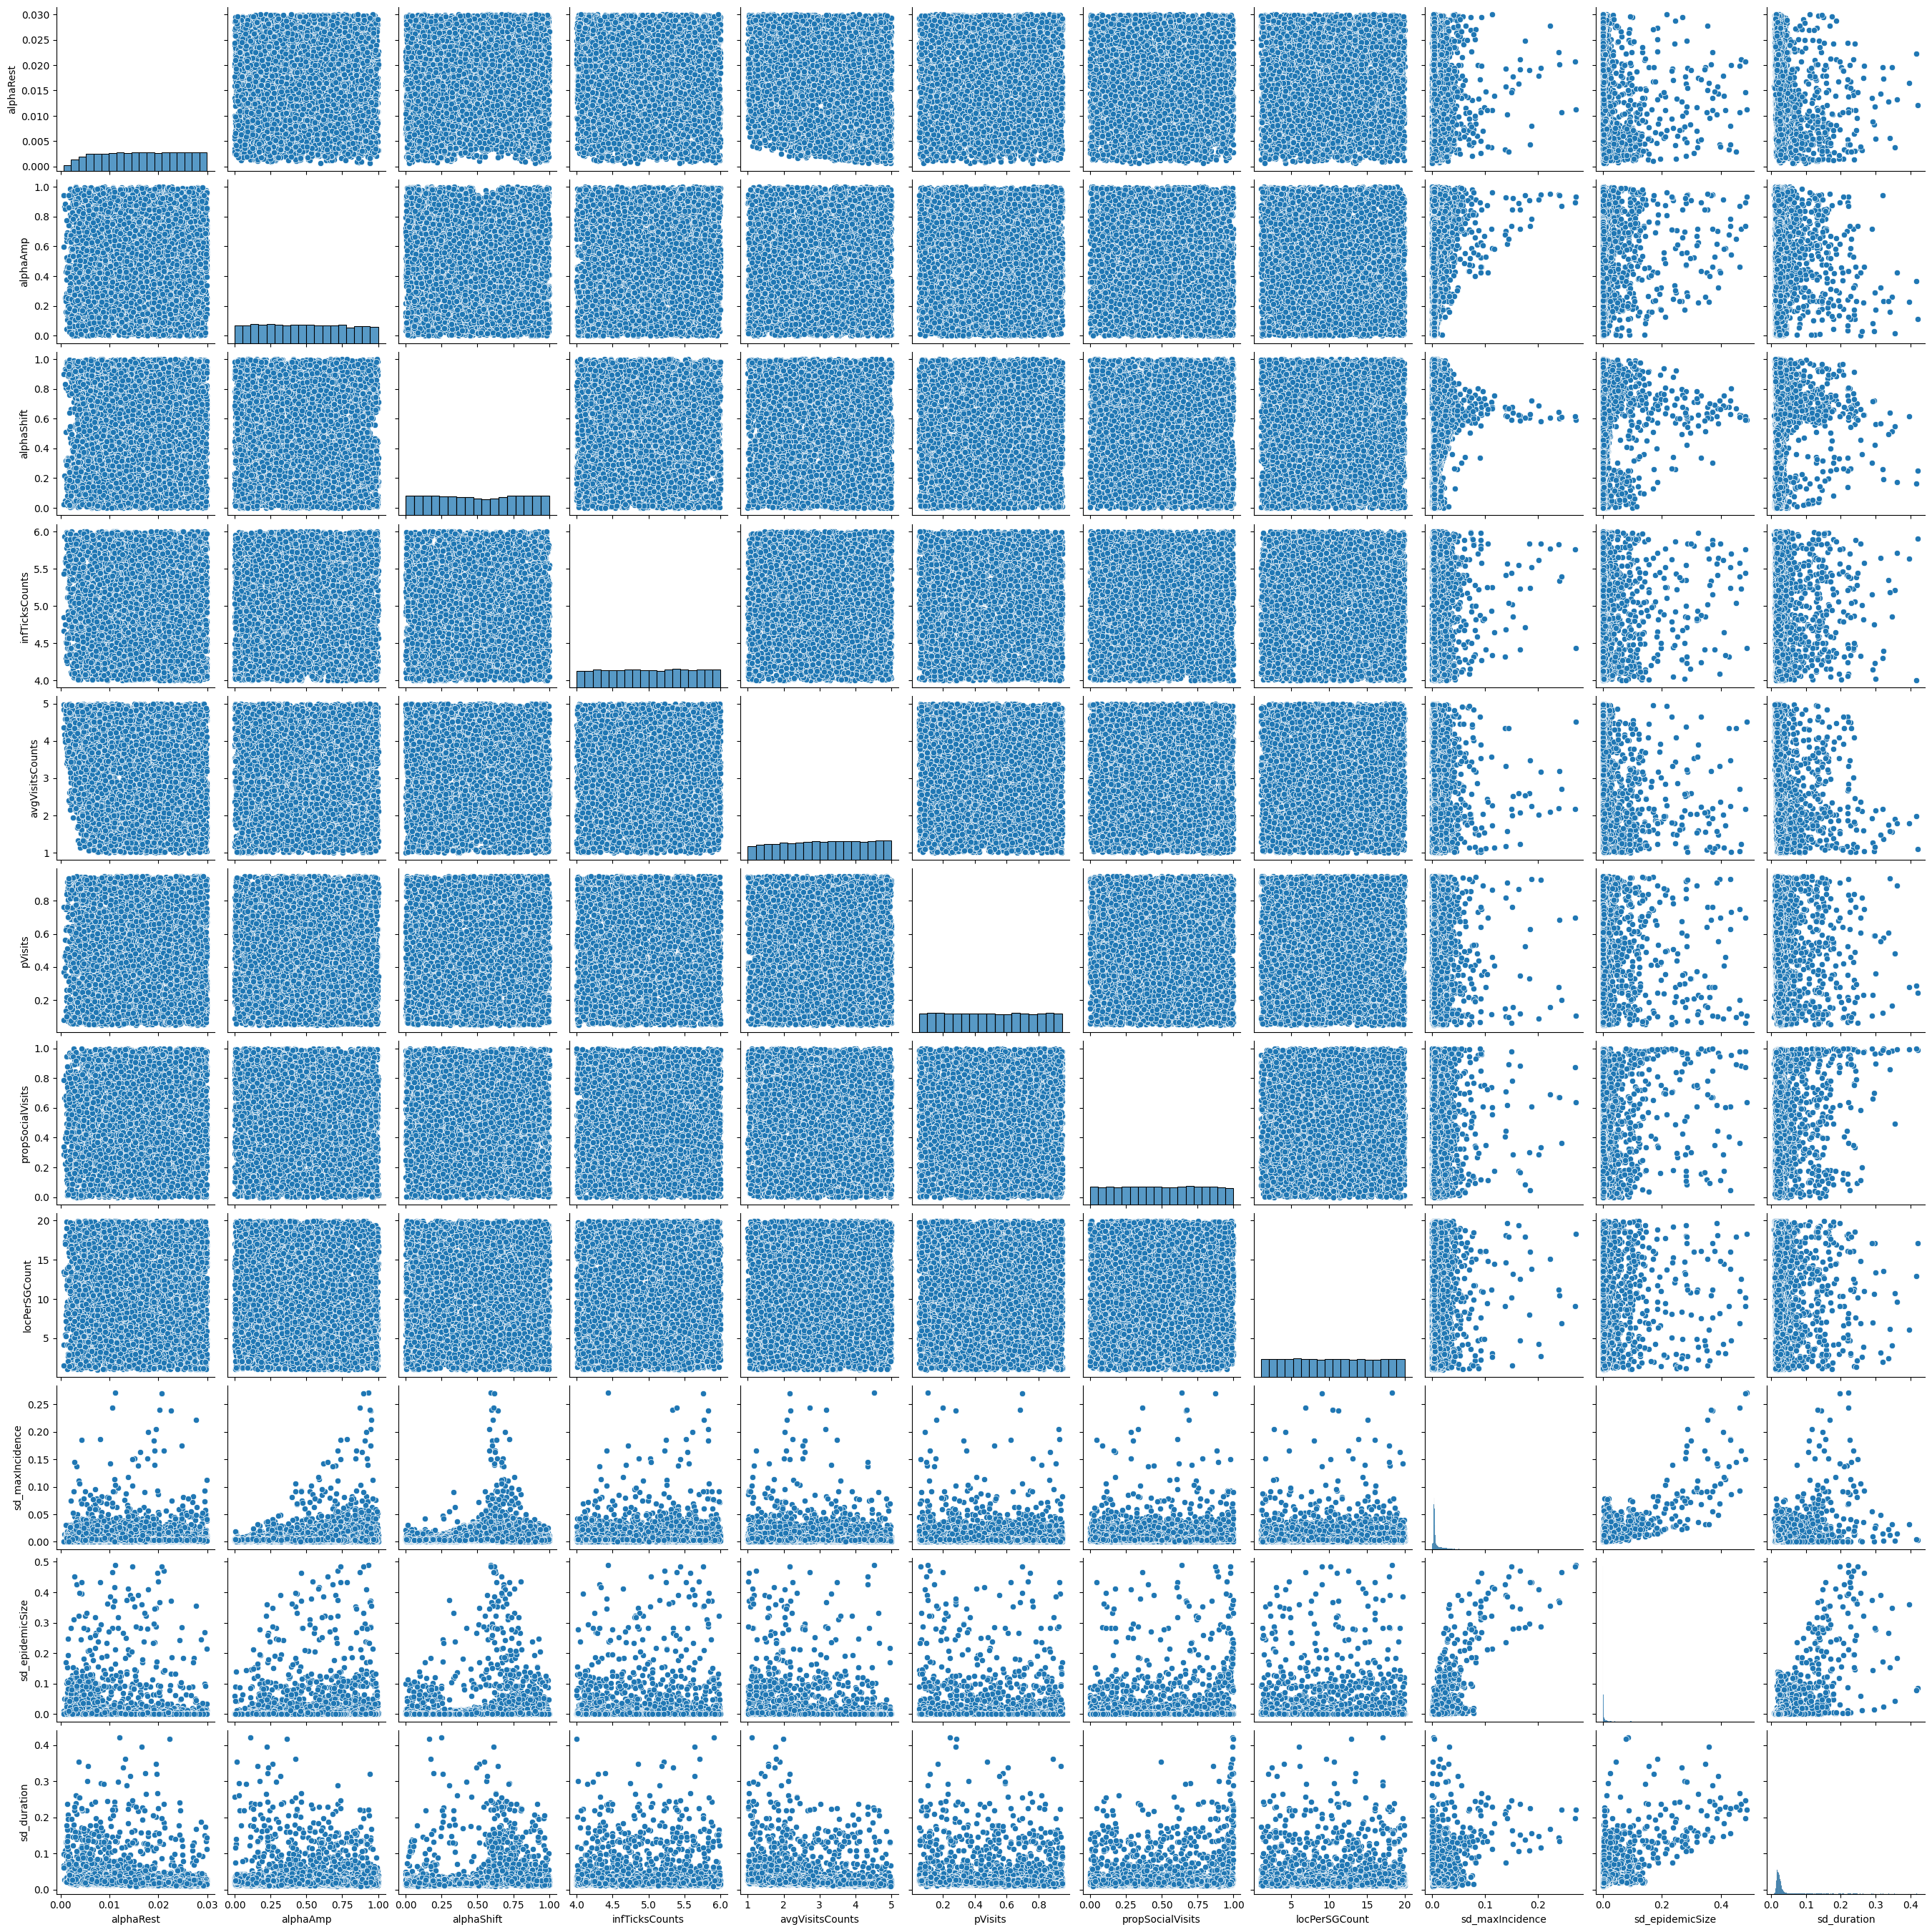

In [23]:
sns.pairplot(train_set)

In [24]:
# select first n

n = 2000

Xtrain = train_set.drop('sd_duration', axis=1)[0:n]
Xtrain = Xtrain.to_numpy()
Ytrain = train_set['sd_duration'][0:n]
Ytrain = Ytrain.to_numpy().reshape(-1, 1)

Xtest = test_set.drop('sd_duration', axis=1)[0:n]
Xtest = Xtest.to_numpy()
Ytest = test_set['sd_duration'][0:n]
Ytest = Ytest.to_numpy().reshape(-1, 1)

### Modeling

#### Multiple Linear Regression

In [25]:
# test a multiple linear regression model
mlr = LinearRegression()
mlr.fit(Xtrain,Ytrain)
Ypred_mlr = mlr.predict(Xtest)

mean_squared_error(Ytest, Ypred_mlr)

0.0004573127993250684

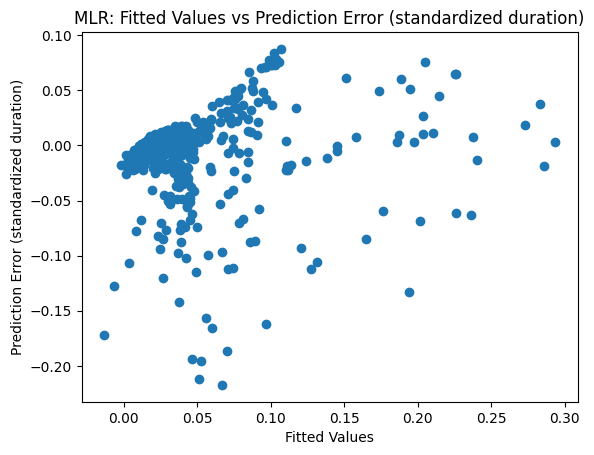

In [26]:
error_mlr = Ypred_mlr - Ytest

plt.scatter(Ypred_mlr, error_mlr)
plt.title("MLR: Fitted Values vs Prediction Error (standardized duration)")
plt.xlabel("Fitted Values")
plt.ylabel("Prediction Error (standardized duration)")
plt.show()

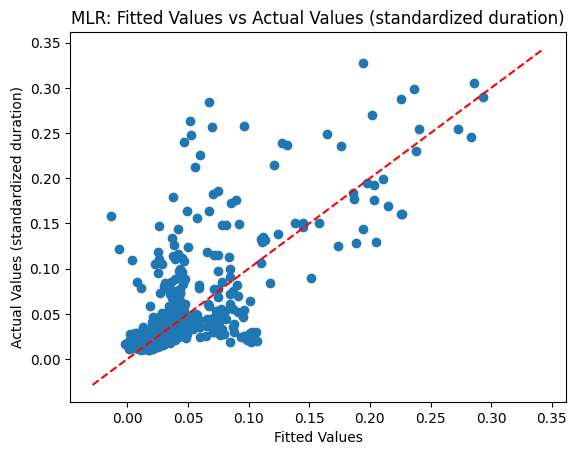

In [27]:
# Fitted Values vs Actual Values

plt.scatter(Ypred_mlr, Ytest)
plt.title("MLR: Fitted Values vs Actual Values (standardized duration)")
plt.xlabel("Fitted Values")
plt.ylabel("Actual Values (standardized duration)")

# to add a y = x line
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
range_max = max(x_max, y_max)
range_min = min(x_min, y_min)
plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line

plt.show()

#### GP

In [28]:
# GP: 
# takes 18 minutes to run with full 5000
# takes 42s with 2000

# create model
mod = gpflow.models.GPR(data=(Xtrain, Ytrain), kernel=gpflow.kernels.SquaredExponential(),)

# train the model
opt = gpflow.optimizers.Scipy()
opt.minimize(mod.training_loss, mod.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -4670.639093099055
        x: [ 3.303e+03  7.868e+05 -7.573e+00]
      nit: 60
      jac: [ 2.459e-04 -8.214e-07 -1.181e-02]
     nfev: 77
     njev: 77
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [29]:
f_mean, f_var = mod.predict_f(Xtest) # returns mean and variance (uncertainty) of function f (no noise)
y_mean, y_var = mod.predict_y(Xtest)

In [30]:
f_pred_df = pd.DataFrame({
    'Mean': f_mean.numpy().flatten(),
    'Variance': f_var.numpy().flatten()
})

f_pred_df.head()

Mean  Variance
0  0.010432  0.000003
1  0.040028  0.000002
2  0.030501  0.000004
3  0.023940  0.000004
4  0.018360  0.000003

In [31]:
y_pred_df = pd.DataFrame({
    'Mean': y_mean.numpy().flatten(),
    'Variance': y_var.numpy().flatten()
})

y_pred_df.head()

Mean  Variance
0  0.010432  0.000518
1  0.040028  0.000517
2  0.030501  0.000518
3  0.023940  0.000518
4  0.018360  0.000517

In [32]:
## 95% confidence intervals
f_lower = f_mean - 1.96 * np.sqrt(f_var)
f_upper = f_mean + 1.96 * np.sqrt(f_var)
y_lower = y_mean - 1.96 * np.sqrt(y_var)
y_upper = y_mean + 1.96 * np.sqrt(y_var)

### Plotting GP

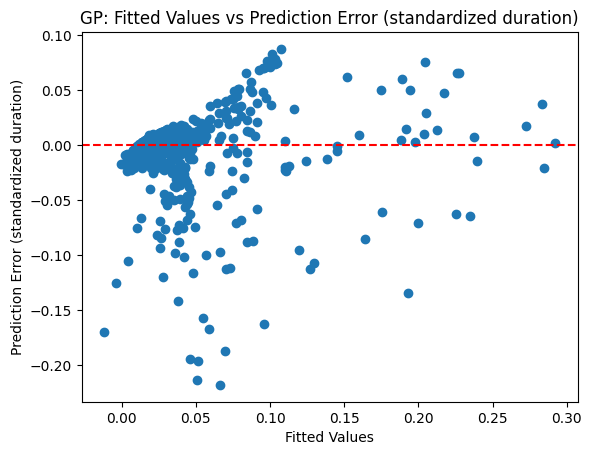

0.00045851892065350665

In [36]:
# Fitted Values vs Prediction Error (standardized duration)
error = y_mean - Ytest

plt.scatter(y_mean, error)
plt.title("GP: Fitted Values vs Prediction Error (standardized duration)")
plt.xlabel("Fitted Values")
plt.ylabel("Prediction Error (standardized duration)")

plt.axhline(y=0, color='red', linestyle='--')

plt.show()

mean_squared_error(Ytest, y_mean)


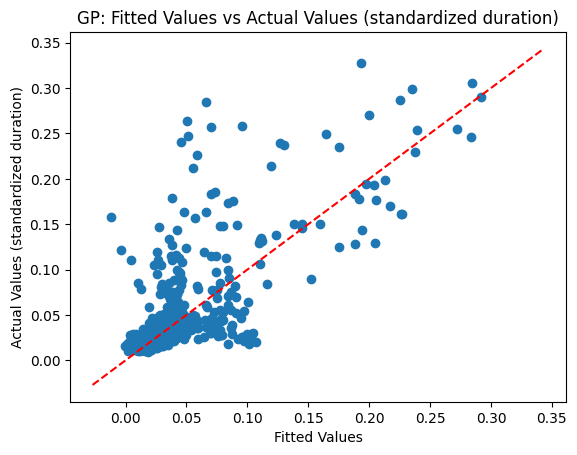

In [35]:
# Fitted Values vs Actual Values

plt.scatter(y_mean, Ytest)
plt.title("GP: Fitted Values vs Actual Values (standardized duration)")
plt.xlabel("Fitted Values")
plt.ylabel("Actual Values (standardized duration)")

# to add a y = x line
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
range_max = max(x_max, y_max)
range_min = min(x_min, y_min)
plt.plot([range_min, range_max], [range_min, range_max], 'r--', label='y=x')  # 'r--' specifies a red dashed line

plt.show()